In [2]:
#Importing necessary packages here
import requests
import json
import numpy as np
from astropy.io import fits
from ccdproc import CCDData, Combiner
from astropy.wcs import WCS
from photutils.detection import DAOStarFinder
from photutils.aperture import aperture_photometry, CircularAperture
import matplotlib.pyplot as plt
import time

C:\Users\queen\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


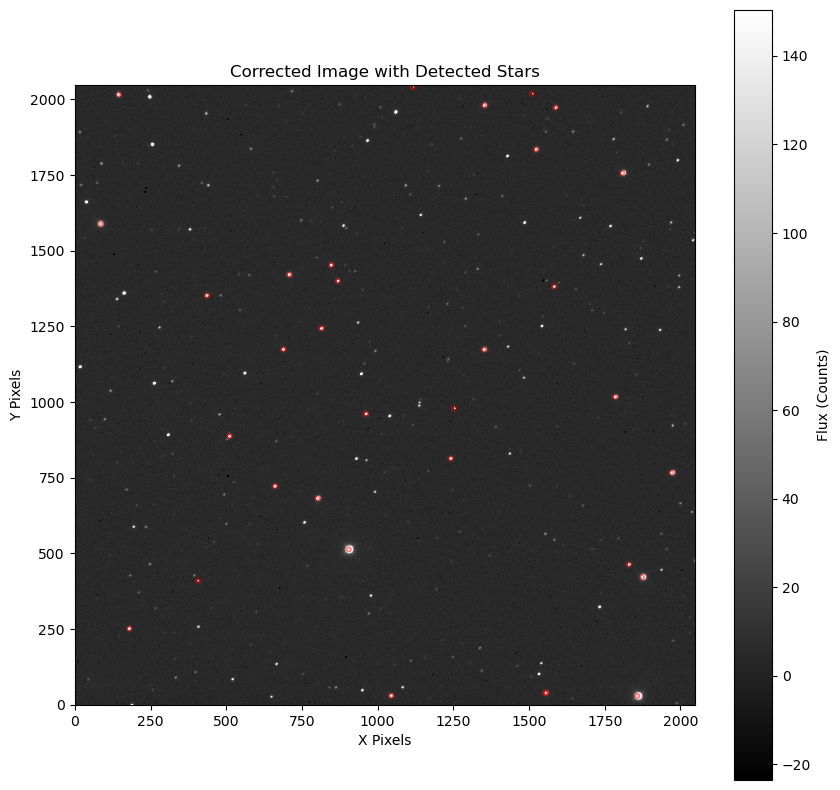

In [3]:
#Function for combining files together, i.e., flats and darks
#The "average" combine method uses mean
    #For each pixel position, sum all pixel values for the image and divide by number of images
#The "median" combine method uses median
    #For each pixel position, sort the values from all images and select the median
#Prefer 'average' if few outliers and less noise. Prefer 'median' if outliers and (relatively) more noise
def load_and_combine(file_list, combine_method = 'average', dark_frame=None):
    ccd_list = []
    
    for file in file_list:
        ccd = CCDData.read(file, unit = 'adu')
        if dark_frame is not None:
            ccd = ccd.subtract(dark_frame, handle_meta = 'first_found')
        ccd_list.append(ccd)

    combiner = Combiner(ccd_list)
    if combine_method == 'average':
        combined_data = combiner.average_combine()
    elif combine_method == 'median':
        combined_data = combiner.median_combine()
        
    return combined_data.data

#Defining functions for Astrometry.net API interaction
#Logging into Astrometry.net using given API key
def astrometry_login(api_key):
    login_url = 'http://nova.astrometry.net/api/login'
    response = requests.post(login_url, data = {'request-json': json.dumps({"apikey": api_key})})
    response.raise_for_status()
    result = response.json()
    try:
        return result['session']
    except:
        raise Exception("Failed to obtain session key from Astrometry.net: " + str(result))

#Submitting target fits file to Astrometry.net
def submit_fits_file(session_key, fits_file_path):
    submit_url = 'http://nova.astrometry.net/api/upload'
    files = {'file': open(fits_file_path, 'rb')}
    data = {'request-json': json.dumps({"session": session_key})}
    response = requests.post(submit_url, files = files, data = data)
    response.raise_for_status()
    result = response.json()
    try:
        return result['subid']
    except:
        raise Exception("Failed to submit FITS file to Astrometry.net: " + str(result))

#Checking submission status of fit file submitting to Astrometry.net
def check_submission_status(session_key, subid):
    status_url = f'http://nova.astrometry.net/api/submissions/{subid}'
    while True:
        response = requests.get(status_url, params = {'session': session_key})
        response.raise_for_status()
        result = response.json()
        if result.get('jobs', []):
            return result['jobs'][0]
        elif 'status' in result and result['status'] == 'failure':
            raise Exception("Submission failed: " + str(result))
        time.sleep(30) #Checking every 30 seconds

#Retrieving results of submitted fit file given to Astrometry.net
def retrieve_results(job_id):
    result_url = f'http://nova.astrometry.net/api/jobs/{job_id}/info/'
    response = requests.get(result_url)
    response.raise_for_status()
    return response.json()

#Establishing Astrometry.net workflow
api_key = 'iffplbgvdtxiobvx' #This is my personal API key
session_key = astrometry_login(api_key)

#Loading selected flat and dark files into two lists
flat_field_paths = ['Calibration-0001flat-g-15s.fit', 'Calibration-0001flat-g-20s.fit']
dark_frame_paths = ['calibration-0001D-15.fit', 'calibration-0001D-20.fit']

#Using load_and_combine function to combine darks and flats
#Includes subtracting dark frames from flat fields before combination
combined_dark = CCDData(load_and_combine(dark_frame_paths, combine_method = 'median'), unit = 'adu')
combined_flat = load_and_combine(flat_field_paths, combine_method = 'median', dark_frame = combined_dark)

#Loading the selected target FITS file
target_fits = fits.open('at2024ajf-0001g.fit')
target_data = target_fits[0].data.astype(float)

#Normalising flat field, subtracting dark frame, flat field correction
combined_flat_normalized = combined_flat / np.median(combined_flat)
target_minus_dark = target_data - combined_dark.data  # Ensure using the .data attribute
corrected_image = target_minus_dark / combined_flat_normalized

#Submitting processed image to Astrometry.net and retrieving WCS information
fits_file_path = 'processed_image.fits'
target_fits.writeto(fits_file_path, overwrite = True)
submission_id = submit_fits_file(session_key, fits_file_path)
job_id = check_submission_status(session_key, submission_id)
wcs_result = retrieve_results(job_id)

#Directly constructing RA and DEC from retrieved WCS information
wcs = WCS(naxis = 2)
wcs.wcs.crval = [wcs_result['calibration']['ra'], wcs_result['calibration']['dec']]
wcs.wcs.cdelt = [wcs_result['calibration']['pixscale'] / 3600] * 2
wcs.wcs.ctype = ["RA---TAN", "DEC--TAN"]

#Using DAOStarFinder to locate stars
#Based on minimum predicted size (fwmh) and minimum predicted brightness (threshold)
daofind = DAOStarFinder(fwhm = 3.5, threshold = 2.2 * np.std(corrected_image))
stars = daofind(corrected_image)

#Calculating pixel positions and performing aperture photometry for brightness in counts
#Adding detections to table from photutils's aperture_photometry function
positions = np.transpose([stars['xcentroid'], stars['ycentroid']])
apertures = CircularAperture(positions, r = 3.0)
phot_table = aperture_photometry(corrected_image, apertures)

#Converting pixel positions to RA and Dec using WCS obtained from Astrometry.net
sky_coords = wcs.all_pix2world(positions, 0)  #0 because Python is 0-indexed

# Add RA and Dec to phot_table
phot_table['ra_deg'] = sky_coords[:, 0]
phot_table['dec_deg'] = sky_coords[:, 1]

#Plotting the corrected image with detected apertures in red
#Can adjust constrast of corrected image with vmin and vmax
plt.figure(figsize = (10, 10))
plt.imshow(corrected_image, cmap = 'gray', origin = 'lower',
           vmin = np.percentile(corrected_image, 0.1), vmax = np.percentile(corrected_image, 99.9))
apertures.plot(color = 'red', lw = 3, alpha = 0.5)
plt.colorbar(label = 'Flux (Counts)')
plt.title('Corrected Image with Detected Stars')
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')
plt.show()

#Closing the target fits file
target_fits.close()

In [4]:
#Showing table of detected stars and relevant information
phot_table.show_in_notebook()

idx,id,xcenter,ycenter,aperture_sum,ra_deg,dec_deg
,,pix,pix,,,
0,1,1857.8322721567947,29.247960900865746,633550.5010703265,87.09951173669027,62.76876165083218
1,2,1042.8685280336865,30.144978288694162,27322.818795672658,86.88595025816475,62.76944601900318
2,3,1554.099708792314,39.059138559389915,24118.42219062014,87.01993568652532,62.77019093297554
3,4,1554.2180211054272,39.65896972182132,24205.467354504624,87.01996768576765,62.77026276853005
4,5,179.17503007291998,251.5666598117231,20924.603055309322,86.65965163988966,62.79625496557929
5,6,406.109976448873,410.13233450901686,7615.967473106522,86.71924564754407,62.815236355584084
6,7,1873.798362381647,422.1514572367797,179773.09542145723,87.10448181750205,62.81585931203247
7,8,1828.152387422764,463.6650035976311,15549.821628797405,87.09258259383648,62.820878423300734
8,9,904.6279653580133,513.6023961365962,799702.3978626698,86.85019060369208,62.82748367932264


In [2]:
#NOT CURRENTLY OPERATIONAL - REQUIRES LINUX
import subprocess
import numpy as np
from astropy.io import fits
from ccdproc import CCDData, Combiner
import matplotlib.pyplot as plt

#Creating the input_list of files to stack
def create_input_list(file_paths, list_filename="input.list"):
    with open(list_filename, 'w') as file:
        for path in file_paths:
            file.write(f"{path}\n")
    return list_filename

#Running SWarp
def run_swarp(input_list, config_file):
    command = ["swarp", f"@{input_list}", "-c", config_file]
    try:
        subprocess.run(command, check=True)
        print("SWarp completed successfully.")
    except subprocess.CalledProcessError as e:
        print(f"An error occurred in SWarp: {e}")

#Copying load_and_combine from earlier code for better readability
def load_and_combine(file_list, combine_method='average', dark_frame=None):
    ccd_list = []
    for file in file_list:
        ccd = CCDData.read(file, unit='adu')
        if dark_frame is not None:
            ccd = ccd.subtract(dark_frame, handle_meta='first_found')
        ccd_list.append(ccd)

    combiner = Combiner(ccd_list)
    if combine_method == 'average':
        combined_data = combiner.average_combine()
    elif combine_method == 'median':
        combined_data = combiner.median_combine()
    return combined_data

#Defining SWarp configuration file path
config_file = "default.swarp"

#Defining files to stack
fits_files = [
    "at2024ajf-0001g.fit",
    "at2024ajf-0001r.fit"
]

#Generating input list for SWarp
input_list_filename = create_input_list(fits_files)

#Combining/stacking images using SWarp
run_swarp(input_list_filename, config_file)

#Reading and displaying the resulting stacked image
stacked_image_path = "coadd.fits"  #Filename given by SWarp output configuration
stacked_image_data = fits.getdata(stacked_image_path)
plt.figure(figsize=(10, 10))
plt.imshow(stacked_image_data, cmap='gray', origin='lower')
plt.colorbar(label='Pixel Value')
plt.title('Stacked Image')
plt.show()

FileNotFoundError: [WinError 2] The system cannot find the file specified